Back to the main [Index](../index.ipynb)

### SED-ML L1V2 specification example

Repressilator example which demonstrates the use of phrasedml with URN examples. 

These examples are the reference examples from the SED-ML specification document available from http://sed-ml.sourceforge.net/documents/sed-ml-L1V2.pdf (Introduction Section).

INFO:root:Initialising BioModels service (WSDL)


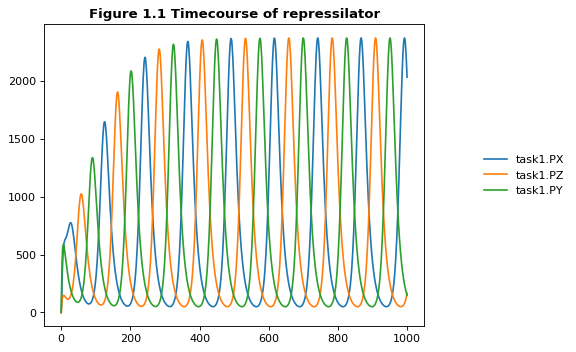

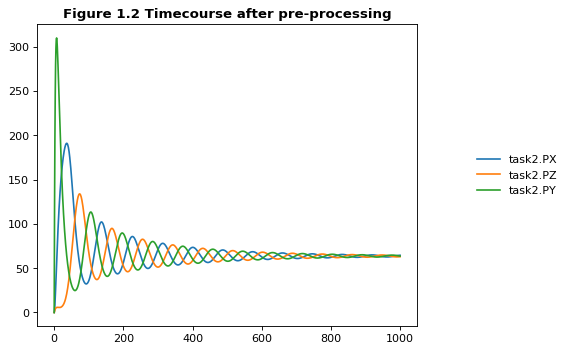

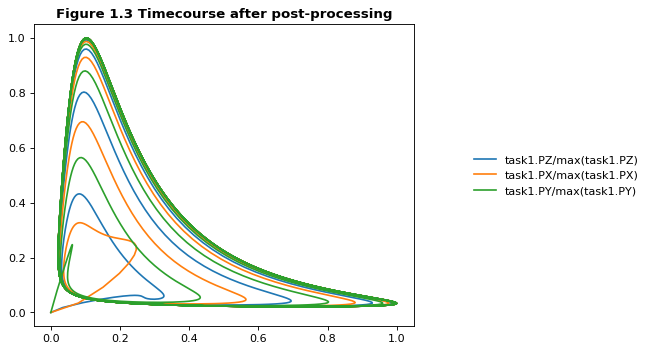

In [1]:
from __future__ import print_function
import tellurium as te, tellurium.temiriam as temiriam
te.setDefaultPlottingEngine('matplotlib')
%matplotlib inline
import phrasedml

# Get SBML from URN and set for phrasedml
urn = "urn:miriam:biomodels.db:BIOMD0000000012"
sbmlStr = temiriam.getSBMLFromBiomodelsURN(urn=urn)
phrasedml.setReferencedSBML('BIOMD0000000012', sbmlStr)

# <SBML species>
#   PX - LacI protein
#   PY - TetR protein
#   PZ - cI protein
#   X - LacI mRNA
#   Y - TetR mRNA
#   Z - cI mRNA

# <SBML parameters>
#   ps_a - tps_active: Transcrition from free promotor in transcripts per second and promotor
#   ps_0 - tps_repr: Transcrition from fully repressed promotor in transcripts per second and promotor

phrasedmlStr = """
    model1 = model "{}"
    model2 = model model1 with ps_0=1.3E-5, ps_a=0.013
    sim1 = simulate uniform(0, 1000, 1000)
    task1 = run sim1 on model1
    task2 = run sim1 on model2

    # A simple timecourse simulation
    plot "Figure 1.1 Timecourse of repressilator" task1.time vs task1.PX, task1.PZ, task1.PY

    # Applying preprocessing
    plot "Figure 1.2 Timecourse after pre-processing" task2.time vs task2.PX, task2.PZ, task2.PY

    # Applying postprocessing
    plot "Figure 1.3 Timecourse after post-processing" task1.PX/max(task1.PX) vs task1.PZ/max(task1.PZ), \
                                                       task1.PY/max(task1.PY) vs task1.PX/max(task1.PX), \
                                                       task1.PZ/max(task1.PZ) vs task1.PY/max(task1.PY)
""".format('BIOMD0000000012')

# convert to SED-ML
sedmlStr = phrasedml.convertString(phrasedmlStr)
if sedmlStr == None:
    raise RuntimeError(phrasedml.getLastError())

# Run the SED-ML file with results written in workingDir
import tempfile, shutil, os
workingDir = tempfile.mkdtemp(suffix="_sedml")
# write out SBML
with open(os.path.join(workingDir, 'BIOMD0000000012'), 'wb') as f:
    f.write(sbmlStr.encode('utf-8'))
te.executeSEDML(sedmlStr, workingDir=workingDir)
shutil.rmtree(workingDir)

### Execute SED-ML Archive

Tellurium can read and execute the SED-ML from a SED-ML archive. This is **not** the same as a COMBINE archive (see below for COMBINE archive examples).

Loading SED-ML archive from path: /home/poltergeist/devel/src/tellurium/tellurium/tests/testdata/sedml/sedx/BIOMD0000000003.sedx
Using /home/poltergeist/devel/src/tellurium/tellurium/tests/testdata/sedml/sedx/_te_BIOMD0000000003 as a working directory


/home/poltergeist/devel/src/tellurium/tellurium/tecombine.py:329: UserWarning:

No 'manifest.xml' in archive, trying to resolve manually



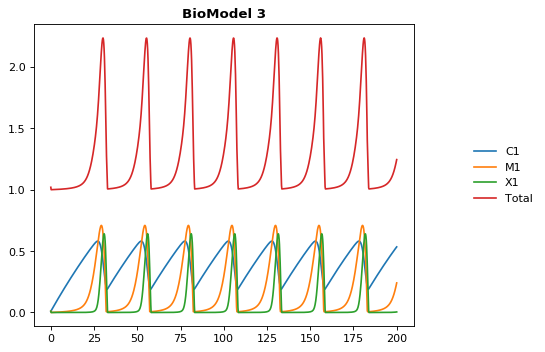

In [23]:
import tellurium as te
from tellurium.tests.testdata import sedxDir
import os
omexPath = os.path.join(sedxDir, "BIOMD0000000003.sedx")
print('Loading SED-ML archive from path: {}'.format(omexPath))
print('Using {} as a working directory'.format(os.path.join(os.path.split(omexPath)[0], '_te_BIOMD0000000003')))

# execute the SED-ML archive
te.executeSEDML(omexPath)

### Inline OMEX and COMBINE archives

Tellurium provides a way to easily edit the contents of COMBINE archives in a human-readable format called inline OMEX. To create a COMBINE archive, simply create a string containing all models (in Antimony format) and all simulations (in PhraSEDML format). Tellurium will transparently convert the Antimony to SBML and PhraSEDML to SED-ML, then execute the resulting SED-ML. The following example will work in either Jupyter or the [Tellurium notebook viewer](http://tellurium.readthedocs.io/en/latest/installation.html#front-end-1-tellurium-notebook). The Tellurium notebook viewer allows you to create specialized cells for inline OMEX, which contain correct syntax-highlighting for the format.

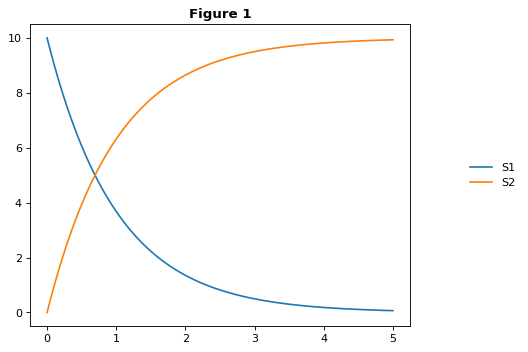

In [3]:
import tellurium as te

antimony_str = '''
model myModel
  S1 -> S2; k1*S1
  S1 = 10; S2 = 0
  k1 = 1
end
'''

phrasedml_str = '''
  model1 = model "myModel"
  sim1 = simulate uniform(0, 5, 100)
  task1 = run sim1 on model1
  plot "Figure 1" time vs S1, S2
'''

# create an inline OMEX (inline representation of a COMBINE archive)
# from the antimony and phrasedml strings
inline_omex = '\n'.join([antimony_str, phrasedml_str])

# execute the inline OMEX
te.executeInlineOmex(inline_omex)
# export to a COMBINE archive
workingDir = tempfile.mkdtemp(suffix="_omex")
te.exportInlineOmex(inline_omex, os.path.join(workingDir, 'archive.omex'))

### OneStep

Running a one step simulation.

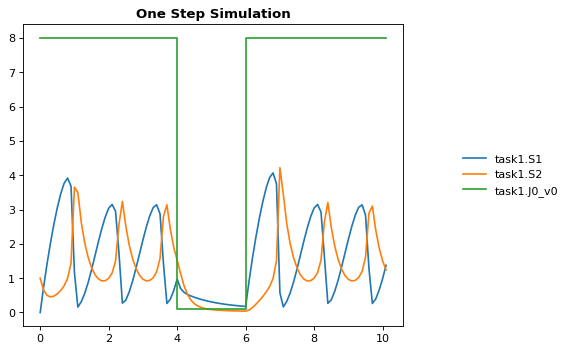

--------------------------------------------------------------------------------
report_1, Repeat: 0
--------------------------------------------------------------------------------
   task1.time  task1.S1  task1.S2  task1.J0_v0
0         0.0  0.000000  1.000000          8.0
1         0.1  0.745536  0.652363          8.0
2         0.1  0.745536  0.652363          8.0
3         0.2  1.417842  0.498250          8.0
4         0.2  1.417842  0.498250          8.0


In [4]:
import tellurium as te

antimony_str = '''
// Created by libAntimony v2.9
model *oneStep()

// Compartments and Species:
compartment compartment_;
species S1 in compartment_, S2 in compartment_, $X0 in compartment_, $X1 in compartment_;
species $X2 in compartment_;

// Reactions:
J0: $X0 => S1; J0_v0;
J1: S1 => $X1; J1_k3*S1;
J2: S1 => S2; (J2_k1*S1 - J2_k_1*S2)*(1 + J2_c*S2^J2_q);
J3: S2 => $X2; J3_k2*S2;

// Species initializations:
S1 = 0;
S2 = 1;
X0 = 1;
X1 = 0;
X2 = 0;

// Compartment initializations:
compartment_ = 1;

// Variable initializations:
J0_v0 = 8;
J1_k3 = 0;
J2_k1 = 1;
J2_k_1 = 0;
J2_c = 1;
J2_q = 3;
J3_k2 = 5;

// Other declarations:
const compartment_, J0_v0, J1_k3, J2_k1, J2_k_1, J2_c, J2_q, J3_k2;
end
'''

phrasedml_str = '''
model1 = model "oneStep"
stepper = simulate onestep(0.1)
task0 = run stepper on model1
task1 = repeat task0 for local.x in uniform(0, 10, 100), J0_v0 = piecewise(8, x<4, 0.1, 4<=x<6, 8)
plot "One Step Simulation" task1.time vs task1.S1, task1.S2, task1.J0_v0
report task1.time vs task1.S1, task1.S2, task1.J0_v0
'''

# create the inline OMEX string
inline_omex = '\n'.join([antimony_str, phrasedml_str])

# export to a COMBINE archive
workingDir = tempfile.mkdtemp(suffix="_omex")
archive_name = os.path.join(workingDir, 'archive.omex')
te.exportInlineOmex(inline_omex, archive_name)
# convert the COMBINE archive back into an 
# inline OMEX (transparently) and execute it
te.convertAndExecuteCombineArchive(archive_name)

### 1d Parameter Scan

This example shows how to perform a one-dimensional parameter scan using Antimony/PhraSEDML and convert the study to a COMBINE archive. The example uses a PhraSEDML repeated task `task1` to run a timecourse simulation `task0` on a model for different values of the parameter `J0_v0`.

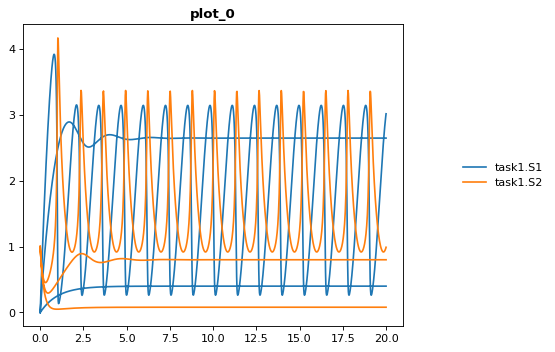

In [13]:
import tellurium as te

antimony_str = '''
// Created by libAntimony v2.9
model *parameterScan1D()

// Compartments and Species:
compartment compartment_;
species S1 in compartment_, S2 in compartment_, $X0 in compartment_, $X1 in compartment_;
species $X2 in compartment_;

// Reactions:
J0: $X0 => S1; J0_v0;
J1: S1 => $X1; J1_k3*S1;
J2: S1 => S2; (J2_k1*S1 - J2_k_1*S2)*(1 + J2_c*S2^J2_q);
J3: S2 => $X2; J3_k2*S2;

// Species initializations:
S1 = 0;
S2 = 1;
X0 = 1;
X1 = 0;
X2 = 0;

// Compartment initializations:
compartment_ = 1;

// Variable initializations:
J0_v0 = 8;
J1_k3 = 0;
J2_k1 = 1;
J2_k_1 = 0;
J2_c = 1;
J2_q = 3;
J3_k2 = 5;

// Other declarations:
const compartment_, J0_v0, J1_k3, J2_k1, J2_k_1, J2_c, J2_q, J3_k2;
end
'''

phrasedml_str = '''
model1 = model "parameterScan1D"
timecourse1 = simulate uniform(0, 20, 1000)
task0 = run timecourse1 on model1
task1 = repeat task0 for J0_v0 in [8, 4, 0.4], reset=true
plot task1.time vs task1.S1, task1.S2
'''

# create the inline OMEX string
inline_omex = '\n'.join([antimony_str, phrasedml_str])

# execute the inline OMEX
te.executeInlineOmex(inline_omex)

### 2d Parameter Scan

There are multiple was to specify the set of values that should be swept over. This example uses two repeated tasks instead of one. It sweeps through a discrete set of values for the parameter `J1_KK2`, and then sweeps through a uniform range for another parameter `J4_KK5`.

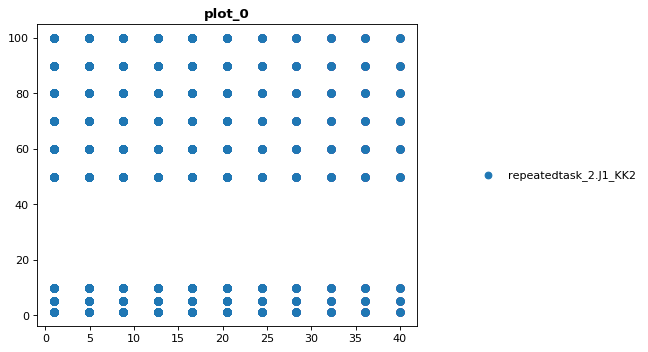

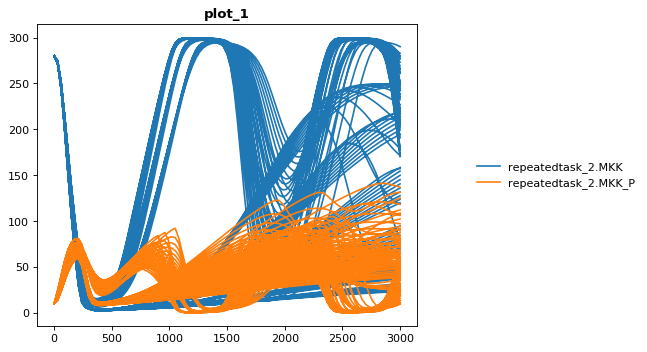

In [14]:
import tellurium as te

antimony_str = '''
// Created by libAntimony v2.9
model *parameterScan2D()

  // Compartments and Species:
  compartment compartment_;
  species MKKK in compartment_, MKKK_P in compartment_, MKK in compartment_;
  species MKK_P in compartment_, MKK_PP in compartment_, MAPK in compartment_;
  species MAPK_P in compartment_, MAPK_PP in compartment_;

  // Reactions:
  J0: MKKK => MKKK_P; (J0_V1*MKKK)/((1 + (MAPK_PP/J0_Ki)^J0_n)*(J0_K1 + MKKK));
  J1: MKKK_P => MKKK; (J1_V2*MKKK_P)/(J1_KK2 + MKKK_P);
  J2: MKK => MKK_P; (J2_k3*MKKK_P*MKK)/(J2_KK3 + MKK);
  J3: MKK_P => MKK_PP; (J3_k4*MKKK_P*MKK_P)/(J3_KK4 + MKK_P);
  J4: MKK_PP => MKK_P; (J4_V5*MKK_PP)/(J4_KK5 + MKK_PP);
  J5: MKK_P => MKK; (J5_V6*MKK_P)/(J5_KK6 + MKK_P);
  J6: MAPK => MAPK_P; (J6_k7*MKK_PP*MAPK)/(J6_KK7 + MAPK);
  J7: MAPK_P => MAPK_PP; (J7_k8*MKK_PP*MAPK_P)/(J7_KK8 + MAPK_P);
  J8: MAPK_PP => MAPK_P; (J8_V9*MAPK_PP)/(J8_KK9 + MAPK_PP);
  J9: MAPK_P => MAPK; (J9_V10*MAPK_P)/(J9_KK10 + MAPK_P);

  // Species initializations:
  MKKK = 90;
  MKKK_P = 10;
  MKK = 280;
  MKK_P = 10;
  MKK_PP = 10;
  MAPK = 280;
  MAPK_P = 10;
  MAPK_PP = 10;

  // Compartment initializations:
  compartment_ = 1;

  // Variable initializations:
  J0_V1 = 2.5;
  J0_Ki = 9;
  J0_n = 1;
  J0_K1 = 10;
  J1_V2 = 0.25;
  J1_KK2 = 8;
  J2_k3 = 0.025;
  J2_KK3 = 15;
  J3_k4 = 0.025;
  J3_KK4 = 15;
  J4_V5 = 0.75;
  J4_KK5 = 15;
  J5_V6 = 0.75;
  J5_KK6 = 15;
  J6_k7 = 0.025;
  J6_KK7 = 15;
  J7_k8 = 0.025;
  J7_KK8 = 15;
  J8_V9 = 0.5;
  J8_KK9 = 15;
  J9_V10 = 0.5;
  J9_KK10 = 15;

  // Other declarations:
  const compartment_, J0_V1, J0_Ki, J0_n, J0_K1, J1_V2, J1_KK2, J2_k3, J2_KK3;
  const J3_k4, J3_KK4, J4_V5, J4_KK5, J5_V6, J5_KK6, J6_k7, J6_KK7, J7_k8;
  const J7_KK8, J8_V9, J8_KK9, J9_V10, J9_KK10;
end
'''

phrasedml_str = '''
  model_3 = model "parameterScan2D"
  sim_repeat = simulate uniform(0,3000,100)
  task_1 = run sim_repeat on model_3
  repeatedtask_1 = repeat task_1 for J1_KK2 in [1, 5, 10, 50, 60, 70, 80, 90, 100], reset=true
  repeatedtask_2 = repeat repeatedtask_1 for J4_KK5 in uniform(1, 40, 10), reset=true
  plot repeatedtask_2.J4_KK5 vs repeatedtask_2.J1_KK2
  plot repeatedtask_2.time vs repeatedtask_2.MKK, repeatedtask_2.MKK_P
'''

# create the inline OMEX string
inline_omex = '\n'.join([antimony_str, phrasedml_str])

# execute the inline OMEX
te.executeInlineOmex(inline_omex)

### Stochastic Simulation and RNG Seeding

It is possible to programatically set the RNG seed of a stochastic simulation in PhraSEDML using the `<simulation-name>.algorithm.seed = <value>` directive. Simulations run with the same seed are identical. If the seed is not specified, a different value is used each time, leading to different results.

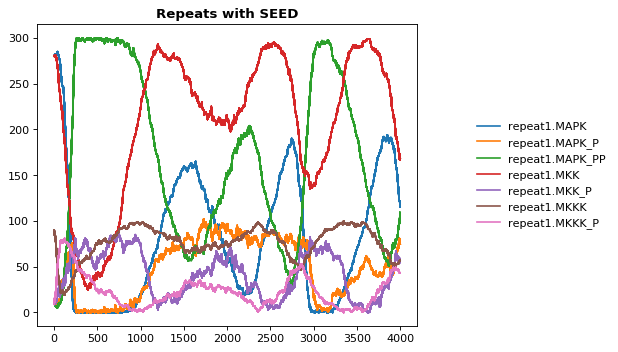

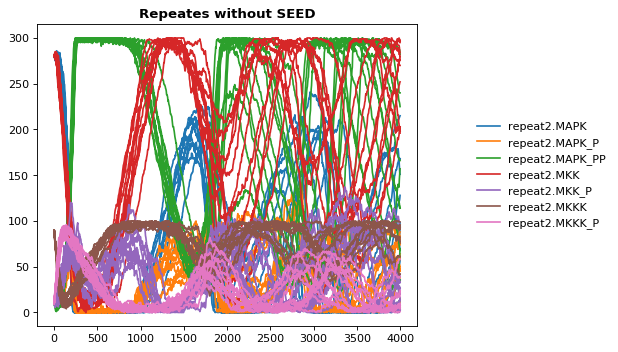

In [15]:
# -*- coding: utf-8 -*-
"""
phrasedml repeated stochastic test
"""
import tellurium as te

antimony_str = '''
// Created by libAntimony v2.9
model *repeatedStochastic()

// Compartments and Species:
compartment compartment_;
species MKKK in compartment_, MKKK_P in compartment_, MKK in compartment_;
species MKK_P in compartment_, MKK_PP in compartment_, MAPK in compartment_;
species MAPK_P in compartment_, MAPK_PP in compartment_;

// Reactions:
J0: MKKK => MKKK_P; (J0_V1*MKKK)/((1 + (MAPK_PP/J0_Ki)^J0_n)*(J0_K1 + MKKK));
J1: MKKK_P => MKKK; (J1_V2*MKKK_P)/(J1_KK2 + MKKK_P);
J2: MKK => MKK_P; (J2_k3*MKKK_P*MKK)/(J2_KK3 + MKK);
J3: MKK_P => MKK_PP; (J3_k4*MKKK_P*MKK_P)/(J3_KK4 + MKK_P);
J4: MKK_PP => MKK_P; (J4_V5*MKK_PP)/(J4_KK5 + MKK_PP);
J5: MKK_P => MKK; (J5_V6*MKK_P)/(J5_KK6 + MKK_P);
J6: MAPK => MAPK_P; (J6_k7*MKK_PP*MAPK)/(J6_KK7 + MAPK);
J7: MAPK_P => MAPK_PP; (J7_k8*MKK_PP*MAPK_P)/(J7_KK8 + MAPK_P);
J8: MAPK_PP => MAPK_P; (J8_V9*MAPK_PP)/(J8_KK9 + MAPK_PP);
J9: MAPK_P => MAPK; (J9_V10*MAPK_P)/(J9_KK10 + MAPK_P);

// Species initializations:
MKKK = 90;
MKKK_P = 10;
MKK = 280;
MKK_P = 10;
MKK_PP = 10;
MAPK = 280;
MAPK_P = 10;
MAPK_PP = 10;

// Compartment initializations:
compartment_ = 1;

// Variable initializations:
J0_V1 = 2.5;
J0_Ki = 9;
J0_n = 1;
J0_K1 = 10;
J1_V2 = 0.25;
J1_KK2 = 8;
J2_k3 = 0.025;
J2_KK3 = 15;
J3_k4 = 0.025;
J3_KK4 = 15;
J4_V5 = 0.75;
J4_KK5 = 15;
J5_V6 = 0.75;
J5_KK6 = 15;
J6_k7 = 0.025;
J6_KK7 = 15;
J7_k8 = 0.025;
J7_KK8 = 15;
J8_V9 = 0.5;
J8_KK9 = 15;
J9_V10 = 0.5;
J9_KK10 = 15;

// Other declarations:
const compartment_, J0_V1, J0_Ki, J0_n, J0_K1, J1_V2, J1_KK2, J2_k3, J2_KK3;
const J3_k4, J3_KK4, J4_V5, J4_KK5, J5_V6, J5_KK6, J6_k7, J6_KK7, J7_k8;
const J7_KK8, J8_V9, J8_KK9, J9_V10, J9_KK10;
end
'''

phrasedml_str = '''
model1 = model "repeatedStochastic"
timecourse1 = simulate uniform_stochastic(0, 4000, 1000)
timecourse1.algorithm.seed = 1003
timecourse2 = simulate uniform_stochastic(0, 4000, 1000)
task1 = run timecourse1 on model1
task2 = run timecourse2 on model1
repeat1 = repeat task1 for local.x in uniform(0, 10, 10), reset=true
repeat2 = repeat task2 for local.x in uniform(0, 10, 10), reset=true
plot "Repeats with SEED" repeat1.time vs repeat1.MAPK, repeat1.MAPK_P, repeat1.MAPK_PP, repeat1.MKK, repeat1.MKK_P, repeat1.MKKK, repeat1.MKKK_P
plot "Repeats without SEED" repeat2.time vs repeat2.MAPK, repeat2.MAPK_P, repeat2.MAPK_PP, repeat2.MKK, repeat2.MKK_P, repeat2.MKKK, repeat2.MKKK_P
'''

# create the inline OMEX string
inline_omex = '\n'.join([antimony_str, phrasedml_str])

# execute the inline OMEX
te.executeInlineOmex(inline_omex)

### Resetting Models

This example is another parameter scan which shows the effect of resetting the model or not after each simulation. When using the repeated task directive in PhraSEDML, you can pass the `reset=true` argument to reset the model to its initial conditions after each repeated simulation. Leaving this argument off causes the model to retain its current state between simulations. In this case, the time value is not reset.

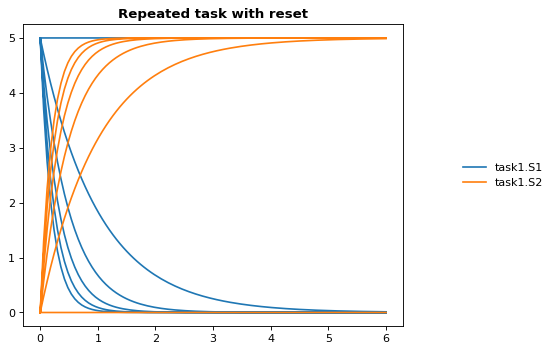

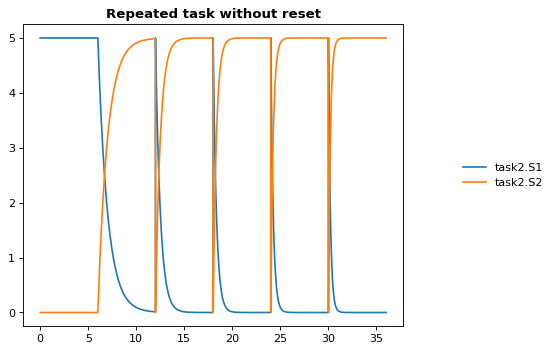

In [20]:
import tellurium as te

antimony_str = """
model case_02
    J0: S1 -> S2; k1*S1;
    S1 = 10.0; S2=0.0;
    k1 = 0.1;
end
"""

phrasedml_str = """
    model0 = model "case_02"
    model1 = model model0 with S1=5.0
    sim0 = simulate uniform(0, 6, 100)
    task0 = run sim0 on model1
    # reset the model after each simulation
    task1 = repeat task0 for k1 in uniform(0.0, 5.0, 5), reset = true
    # show the effect of not resetting for comparison
    task2 = repeat task0 for k1 in uniform(0.0, 5.0, 5)
    plot "Repeated task with reset"    task1.time vs task1.S1, task1.S2
    plot "Repeated task without reset" task2.time vs task2.S1, task2.S2
"""

# create the inline OMEX string
inline_omex = '\n'.join([antimony_str, phrasedml_str])

# execute the inline OMEX
te.executeInlineOmex(inline_omex)

### 3d Plotting

This example shows how to use PhraSEDML to perform 3d plotting. The syntax is `plot <x> vs <y> vs <z>`, where `<x>`, `<y>`, and `<z>` are references to model state variables used in specific tasks.

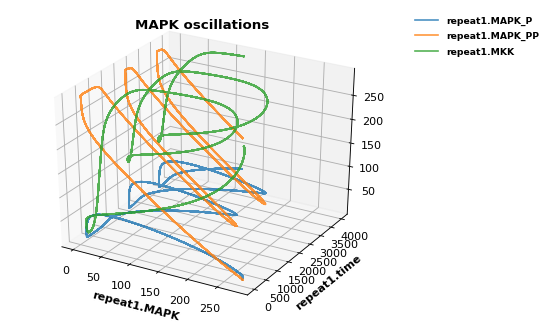

In [21]:
import tellurium as te

antimony_str = '''
// Created by libAntimony v2.9
model *case_09()

// Compartments and Species:
compartment compartment_;
species MKKK in compartment_, MKKK_P in compartment_, MKK in compartment_;
species MKK_P in compartment_, MKK_PP in compartment_, MAPK in compartment_;
species MAPK_P in compartment_, MAPK_PP in compartment_;

// Reactions:
J0: MKKK => MKKK_P; (J0_V1*MKKK)/((1 + (MAPK_PP/J0_Ki)^J0_n)*(J0_K1 + MKKK));
J1: MKKK_P => MKKK; (J1_V2*MKKK_P)/(J1_KK2 + MKKK_P);
J2: MKK => MKK_P; (J2_k3*MKKK_P*MKK)/(J2_KK3 + MKK);
J3: MKK_P => MKK_PP; (J3_k4*MKKK_P*MKK_P)/(J3_KK4 + MKK_P);
J4: MKK_PP => MKK_P; (J4_V5*MKK_PP)/(J4_KK5 + MKK_PP);
J5: MKK_P => MKK; (J5_V6*MKK_P)/(J5_KK6 + MKK_P);
J6: MAPK => MAPK_P; (J6_k7*MKK_PP*MAPK)/(J6_KK7 + MAPK);
J7: MAPK_P => MAPK_PP; (J7_k8*MKK_PP*MAPK_P)/(J7_KK8 + MAPK_P);
J8: MAPK_PP => MAPK_P; (J8_V9*MAPK_PP)/(J8_KK9 + MAPK_PP);
J9: MAPK_P => MAPK; (J9_V10*MAPK_P)/(J9_KK10 + MAPK_P);

// Species initializations:
MKKK = 90;
MKKK_P = 10;
MKK = 280;
MKK_P = 10;
MKK_PP = 10;
MAPK = 280;
MAPK_P = 10;
MAPK_PP = 10;

// Compartment initializations:
compartment_ = 1;

// Variable initializations:
J0_V1 = 2.5;
J0_Ki = 9;
J0_n = 1;
J0_K1 = 10;
J1_V2 = 0.25;
J1_KK2 = 8;
J2_k3 = 0.025;
J2_KK3 = 15;
J3_k4 = 0.025;
J3_KK4 = 15;
J4_V5 = 0.75;
J4_KK5 = 15;
J5_V6 = 0.75;
J5_KK6 = 15;
J6_k7 = 0.025;
J6_KK7 = 15;
J7_k8 = 0.025;
J7_KK8 = 15;
J8_V9 = 0.5;
J8_KK9 = 15;
J9_V10 = 0.5;
J9_KK10 = 15;

// Other declarations:
const compartment_, J0_V1, J0_Ki, J0_n, J0_K1, J1_V2, J1_KK2, J2_k3, J2_KK3;
const J3_k4, J3_KK4, J4_V5, J4_KK5, J5_V6, J5_KK6, J6_k7, J6_KK7, J7_k8;
const J7_KK8, J8_V9, J8_KK9, J9_V10, J9_KK10;
end
'''

phrasedml_str = '''
  mod1 = model "case_09"
  # sim1 = simulate uniform_stochastic(0, 4000, 1000)
  sim1 = simulate uniform(0, 4000, 1000)
  task1 = run sim1 on mod1
  repeat1 = repeat task1 for local.x in uniform(0, 10, 10), reset=true
  plot "MAPK oscillations" repeat1.MAPK vs repeat1.time vs repeat1.MAPK_P, repeat1.MAPK vs repeat1.time vs repeat1.MAPK_PP, repeat1.MAPK vs repeat1.time vs repeat1.MKK
  # report repeat1.MAPK vs repeat1.time vs repeat1.MAPK_P, repeat1.MAPK vs repeat1.time vs repeat1.MAPK_PP, repeat1.MAPK vs repeat1.time vs repeat1.MKK
'''

# create the inline OMEX string
inline_omex = '\n'.join([antimony_str, phrasedml_str])

# execute the inline OMEX
te.executeInlineOmex(inline_omex)
